# Holder simulation:-

In [1]:
using Plots
using LaTeXStrings
using JLD2

### Functions

In [170]:
function vec_f(rb::Array, ra::Array)   # returns vector from rb to ra
    return (rb - ra)
end

function mod_f(rb::Array, ra::Array)  # Returns distance between rb and ra
    mod = sqrt((rb[1]-ra[1])^2 + (rb[2]-ra[2])^2)  # sqrt(delta_x^2 + delta_y^2)
    return (mod)
end

mod_f (generic function with 1 method)

In [ ]:
sig = 1.0    # effective filament diameter
N = 128
ro = 1.5*sig
dt = 0.0001
total_time = 300

L = N*ro
kb = 1.0/300   # from kb*T=1 
t = 1.2/kb  # temperature
ks = 30   # spring constant
kappa = 0
eps = kb*t  # characteristic volume-exclusion energy (Kb*T)
fp = 5000*kb*t/(L^2)*5
fric_coeff =  0.7 #6*pi*(10^(-3))*ro
tau = (L^2)*fric_coeff*(N+1)/(4*kb*t)

x = Array(1:N)*1.6   # Current x positions of all particles
y = zeros(N)   # Current y positions of all particles
big_x = [x]   # x locations at all times, all particles
big_y = [y]   # y locations at all times, all particles
x_dot = zeros(N)   # current speed in x direction, all particles
y_dot = zeros(N)   # current spped in y direction, all particles
x_ddot = zeros(N)  # the double dot
y_ddot = zeros(N)  # the souble dot

In [172]:
println("kbt = ", kb*t)
println("ks = ", ks)
println("kappa = ", kappa)
println("fp = ", fp)
println("friction coefficient = ", fric_coeff)
println("tau = ", tau)

kbt = 1.2
ks = 30
kappa = 0
fp = 0.8138020833333331
friction coefficient = 0.7
tau = 693504.0


In [173]:
function dot(v1::Array , v2::Array)
    return (v1[1]*v2[1] + v1[2]*v2[2])
end

function cosine(ri::Array, rj::Array, rk::Array)
    cs = dot(rj-ri, rk-rj) / ((mod_f(rj, rk))*(mod_f(rj, ri)))
    return (cs)
end

cosine (generic function with 1 method)

In [175]:
function Fbond_f(r_i, r_j, r_k) 
    F_bond = ks*( ( mod_f(r_k, r_j)) *vec_f(r_k, r_j)/mod_f(r_k, r_j)#/(1 - ( mod_f(r_k, r_j)^2)/ro^2)
                +( mod_f(r_i, r_j))*vec_f(r_i, r_j)/mod_f(r_i, r_j))#/(1 - ( mod_f(r_i, r_j)^2)/ro^2))
    return (F_bond)
end

function Fbond_end_f(rb, ra)
    return ( ks*( ( mod_f(rb, ra)-ro )*vec_f(rb, ra)/mod_f(rb, ra)))#/(1 - ( mod_f(rb, ra)^2)/ro^2)
end

function Fangle_f(r_i, r_j, r_k, kappa)  # kappa = bending rigidity
    if (cosine(r_i, r_j, r_k) > 1.0)
        cos1 = 1.0
    else 
        cos1 = cosine(r_i, r_j, r_k)
    end
    theta = acos(cos1)
    F_angle = kappa*sin(pi - theta)*(vec_f(r_i-r_j, r_j-r_k) / mod_f(r_i-r_j, r_k-r_j)) 
    return (F_angle)
end 

function Fev_f(r_i, r_j)
    r = mod_f(r_i, r_j)
    if (r < 2^(1/6)*sig && r_i != r_j)
        Uev = -4*eps*( -12*(r^(-13))*(sig)^12 + 6*(r^(-7))*(sig)^6 ) #+ eps  #Force due to excluded volume parameter
        return ( Uev*(vec_f(r_i, r_j)/r))
    else
        return ([0.0, 0.0])
    end
end

# Thermal force
function Fkbt_f()
    var = 4*kb*t*fric_coeff/dt
    return [randn(), randn()]*sqrt(var)
end

# Tangential force
function Fp_f(rb, ra, fp)
    return ( fp*vec_f(rb, ra))
end

r(j::Int) = [x[j], y[j]]   # x&y cordinates of current particles

# calculating lennard jones interaction on mth particle (function)
function lj_f(m::Array)
    force = [0.0, 0.0]
    for k in (1:N)
        force += Fev_f(m, r(k))
    end
    return (force)
end

lj_f (generic function with 1 method)

In [176]:
Threads.nthreads()

4

In [177]:
f_tot = []  # stores total force on bead under considiration
for i in (1: Threads.nthreads())
    append!(f_tot, [[0.0, 0.0]])
end

num_steps = ceil(total_time/dt)

3.0e6

In [ ]:
for i in (1: num_steps)
    Threads.@threads for j in (2:N-1)
        f_tot[Threads.threadid()] = Fbond_f(r(j-1), r(j) , r(j+1)) + 
                                    Fangle_f(r(j-1), r(j), r(j+1), kappa) + 
                                    Fkbt_f() + 
                                    #Fp_f(r(j), r(j+1), fp) + 
                                    lj_f(r(j))
                                    
        x_ddot[j], y_ddot[j] = f_tot[Threads.threadid()][1], f_tot[Threads.threadid()][2]
    end
    x_ddot[1], y_ddot[1] =Fbond_end_f(r(2), r(1)) + 
                        #-Fangle_f(r(1), r(2), r(3), kappa)*0.5 + 
                        Fkbt_f() + 
                        #Fp_f(r(1), r(2), fp) + 
                        lj_f(r(1))
                        
    x_ddot[N], y_ddot[N] =Fbond_end_f( r(N-1), r(N)) + 
                        Fkbt_f() + 
                        lj_f(r(N))

    x_ddot = x_ddot - fric_coeff*x_dot
    y_ddot = y_ddot - fric_coeff*y_dot

    # Here comes the integration:-
    x_dot = x_dot + x_ddot*dt
    y_dot = y_dot + y_ddot*dt
    x = x + x_dot*dt                                                                                                                                                        
    y = y + y_dot*dt
    if (i%1000 == 0.0)
        append!(big_x, [x])
        append!(big_y, [y])
        if (i%10000 == 0)
            print(i/10000)
        end
    end
end

In [180]:
f_tot

4-element Vector{Any}:
 [-83.99598689987205, 160.2776958808561]
 [-161.03848251173685, 209.09856571400152]
 [38.308905150816635, -4.009012077906872]
 [-38.88788682190424, -124.6947097539186]

In [188]:
size(big_x)

(3001,)

### Simulations

In [181]:
avgx, avgy = [], []
for i in 1: length(big_x)
    ax, ay = 0, 0
    for j in 1:N
        ax += big_x[i][j]
        ay += big_y[i][j]
    end
    append!(avgx, ax/N)
    append!(avgy, ay/N)
end

┌ Info: Saved animation to c:\Users\sudeep maurya\Desktop\Write Notebooks\lmao23.gif
└ @ Plots C:\Users\sudeep maurya\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\sudeep maurya\\Desktop\\Write Notebooks\\lmao23.gif")
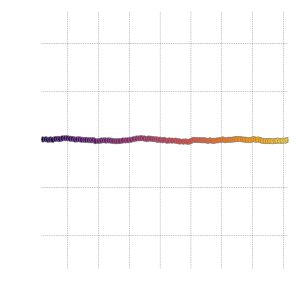

In [187]:
dm = 180
scale = 20
sz = 300

anim = @animate for q in (1: length(big_x)/scale)
    plot(big_x[Int(q*scale)], big_y[Int(q*scale)], size = [sz,sz], legend = false, 
        #ylim=(-dm, +dm),  
        #xlim=(-dm, +dm), 
        xlim=(avgx[Int(q*scale)]-80, avgx[Int(q*scale)]+80),
        ylim=(avgy[Int(q*scale)]-80, avgy[Int(q*scale)]+80),
        marker=3,
        markerstrokecolor = "gray", 
        lc=:balance,
        marker_z=(1:N),
        #title = "Polymer",
        showaxis=false,
        gridstyle= :dot,
        gridalpha= 0.5
        )
end

gif(anim, "lmao23.gif", fps=20)

In [189]:
## Test 
n = -10
r1 = [x[19], y[19]]
r2 = [x[20], y[20]]
r3 = [x[21], y[21]]

println(vec_f(r1,r2), ", ", mod_f(r1,r2),", ", vec_f(r1,r2)/mod_f(r1,r2))
println(Fbond_f(r1, r2, r3))
println(Fangle_f(r1, r2, r3, kappa))
println( Fev_f(r1, r2))
println(Fkbt_f())
println(Fp_f(r1,r2, fp))
println(ks)
println(Fbond_end_f(r1,r2) )

[-0.8837604470886689, 1.2265876469560908], 1.5118034870655788, [-0.5845736265657477, 0.811340665271851]
[1.8221121302357124, 6.29263058360408]
[0.0, 0.0]
[0.0, 0.0]
[-242.67843948181132, 229.12198235610938]
[-0.7192060930083567, 0.9981995824837976]
30
[-0.20700021720141826, 0.2872994714494309]


In [190]:
function lmao(a)
    if (a%2 == 0)
        return(0.0)
    elseif  (a%2 == 1)
        return(1.0)
    end
end

lmao (generic function with 1 method)

In [191]:
n = 20
data1 = zeros(Float64, n)
data2 = zeros(Float64, n)
data3 = zeros(Float64, n)
d = zeros(Float64, 4)

Threads.@threads for k in (1:n)
    d[Threads.threadid()] = lmao(k)
    data1[k] = d[Threads.threadid()]
    data2[k] = k
    data3[k] = Threads.threadid()
end

println(data1)
println(data2)
println(data3)

[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0]


In [276]:
save_object("big_x(7dec2023)", big_x)

In [277]:
save_object("big_y(7dec2023)", big_y)

# Analysis

In [278]:
#big_x = load_object("big_x(15Jul)[dt=10^-6]")
#big_y = load_object("big_y(15Jul)[dt=10^-6]")

In [192]:
function dot(v1::Array , v2::Array)
    return (v1[1]*v2[1] + v1[2]*v2[2])
end

function mod_f(rb::Array, ra::Array)  # Returns distance between rb and ra
    mod = sqrt((rb[1]-ra[1])^2 + (rb[2]-ra[2])^2)  # sqrt(delta_x^2 + delta_y^2)
    return (mod)
end

function cosine(ri::Array, rj::Array, rk::Array)
    cs = dot(rj-ri, rk-rj) / ((mod_f(rj, rk))*(mod_f(rj, ri)))
    return (cs)
end

function angle(dr)
    r = sqrt(dr[1]^2 + dr[2]^2)
    s = 0 
    if (dr[1]>0 && dr[2]>0)
        s = acos(dr[1] / r)
    elseif (dr[1]<0 && dr[2]>0)
        s = acos(dr[1] / r)
    elseif (dr[1]<0 && dr[2]<0)
        s = pi + acos(-dr[1] / r)
    elseif (dr[1]>0 && dr[2]<0)
        s = pi + acos(-dr[1] / r)
    elseif (dr[1] == 0)
        if (dr[2] > 0)
            s = pi/2
        else 
            s = pi + pi/2
        end
    elseif (dr[2] == 0)
        if (dr[1] > 0)
            s = 0
        else
            s = pi
        end
    end
    return (s)
end

function angle1(ri::Array, rj::Array, rk::Array)
    ##
    dr1 = rj - ri
    dr2 = rk - rj
    if (cosine(ri::Array, rj::Array, rk::Array) <= 1.0)
        a = acos(cosine(ri::Array, rj::Array, rk::Array))  # angle between dr1 and dr2
    else 
        a = 1
    end
    a1 = angle(dr1)
    a2 = angle(dr2)
    
    if (a1>0 && a1<pi) 
        if (a2>a1 && a2<(a1+pi))
            a *= (-1)
        end
    
    elseif (a1>pi) 
        if (a2<a1 && a2>(a1-pi))
            a *= (1)
        else 
            a *= (-1)
        end
    end
    return (a)
end

function spi_num(x::Array, y::Array)
    ang = 0
    for i in (1:N-2)
        ri = [x[i  ], y[i  ]]
        rj = [x[i+1], y[i+1]]
        rk = [x[i+2], y[i+2]]
        ang += angle1(ri, rj, rk)
    end
    return (ang / (2*pi))
end

spi_num (generic function with 1 method)

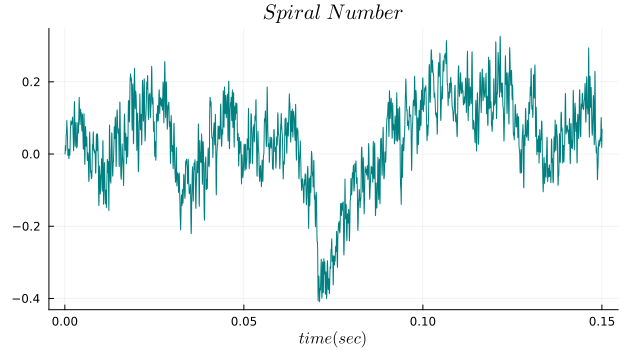

In [193]:
spiral_number = zeros(Float64, length(big_x))
for i in (1: length(big_x))
    spiral_number[i] = spi_num(big_x[i], big_y[i])
end

tm = []
for i in (1: length(big_x))
    append!(tm, i*dt/2)
end

sz = 350
plot(tm, spiral_number,
    size = [1.8*sz, 1.0*sz],
    title=L"Spiral \ Number",
    legend=false,
    xlabel=L"time (sec)",
    color="teal"
    )

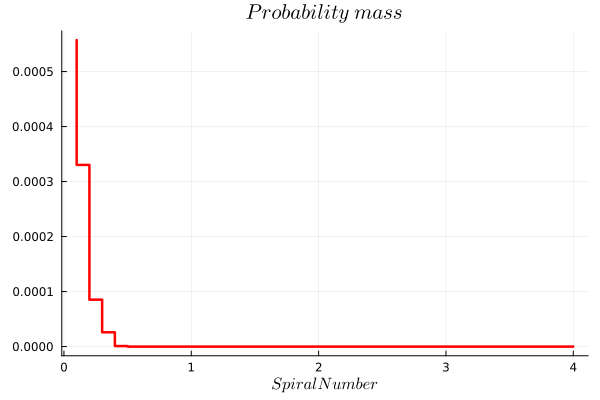

In [200]:
bin = zeros(Int, 4*10)

for i in spiral_number
    b = abs(i)
    for j in (1:40)
        if ( b>((j-1)/10) && b<((j)/10) ) 
            bin[j] += 1
        end
    end
end

plot((1:40)./10, (bin./num_steps), seriestype=:steppre,
        linewidth=2.5,
        legend=false,
        title=L"Probability \ mass",
        color="red",
        xlabel=L"SpiralNumber")

## Angle force and potential:-

In [194]:
th = range(0, pi, 300)
k = 1.0
U = []

Any[]

In [195]:
r1 = [1, 0]
for i in (1:300)
    pot = (k/2)*dot(r1 + [cos(th[i]), sin(th[i])], r1 + [cos(th[i]), sin(th[i])])
    append!(U, pot)
end

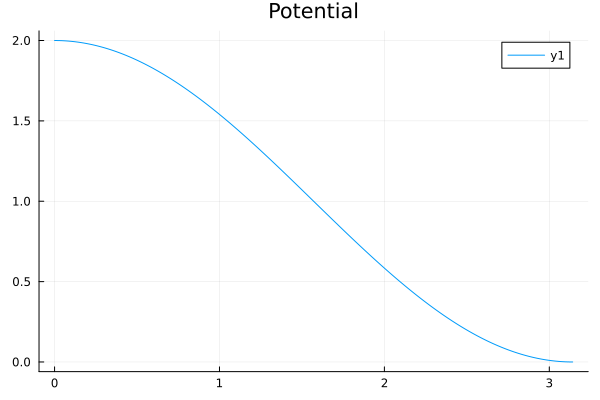

In [196]:
plot(th, U, title="Potential")

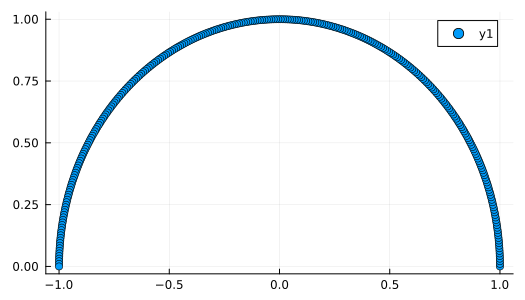

In [197]:
scatter(cos.(th), sin.(th), size=[525, 300])

In [198]:
F = []

for i in (1:300)
    force = Fangle_f([1,0], [0,0], [cos(th[i]), sin(th[i])], k)
    append!(F, mod_f(force, [0,0]))
end

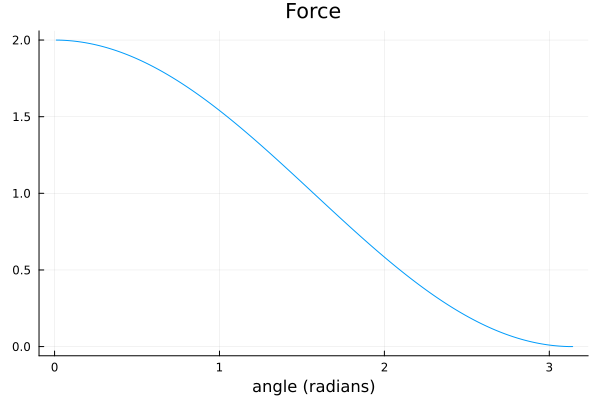

In [199]:
plot(th, F, title="Force", 
    xlabel="angle (radians)", legend=false)